Assignment 1 - analysis of movie reviews
===

*Due: November 29 2022*

In this assignment you will use web scraping tools to extract the reviews of 2 movies - Dune and Interstellar  - from Rotten Tomatoes.

You will save these reviews as text - strings - in a database that you will save as a CSV file.

After obtaining a dataset of Dune and Interstellar reviews, for each movie you will obtain:

- Wordclouds

- Word Frequency Barplots with the 20 most-frequent words: frequency as Y-axis and words as X-axis

- Sentiment scores for each movie using AFINN

## Define function to download reviews

In [82]:
import jupyter_black

jupyter_black.load()

import pandas as pd
import requests
import re
import time
import html
import regex as re
import json, os
import matplotlib.pyplot as plt
import contractions
from wordcloud import WordCloud
import nltk
from afinn import Afinn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader_sia = SentimentIntensityAnalyzer()
afinn = Afinn()


headers = {
    "Referer": "https://www.rottentomatoes.com/m/notebook/reviews?type=user",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest",
}

s = requests.Session()


def get_reviews(url):
    r = requests.get(url)
    movie_id = re.findall(r'(?<=movieId":")(.*)(?=","type)', r.text)[0]

    api_url = f"https://www.rottentomatoes.com/napi/movie/{movie_id}/criticsReviews/all"  # use reviews/userfor user reviews

    payload = {
        "direction": "next",
        "endCursor": "",
        "startCursor": "",
    }

    review_data = []

    while True:
        r = s.get(api_url, headers=headers, params=payload)
        data = r.json()

        # unescape html
        for i, review in enumerate(data["reviews"]):
            data["reviews"][i]["quotes"] = html.unescape(review["quote"])

        if not data["pageInfo"]["hasNextPage"]:
            break

        payload["endCursor"] = data["pageInfo"]["endCursor"]
        payload["startCursor"] = (
            data["pageInfo"]["startCursor"]
            if data["pageInfo"].get("startCursor")
            else ""
        )

        review_data.extend(data["reviews"])
        time.sleep(1)

    return review_data


def plot_wordcloud(df, name="", max_words=20):
    # One long string
    word_string = " ".join(list(df.quotes))
    word_string = word_string.lower()
    word_string = contractions.fix(word_string)
    word_string = re.sub(",|\.|--|!|\?|:|\"|\(|\)|\[|\]|\s-\s|/|'s|'", " ", word_string)

    ## here we set the parameters for wordcloud function
    wordcloud = WordCloud(
        collocations=False,
        max_font_size=100,
        width=800,
        height=600,
        colormap="Set2",
        max_words=max_words,
        background_color="white",
    ).generate(word_string)

    if name != "":
        name = "_" + name + "_"

    ## these are matplot lib commants to show the image, and save as a figure (see it appear in the files manu on the left)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("wordcloud" + name + ".png")
    plt.show()


def create_wordstring(df):
    """
    returns a clean wordstring
    """

    # One long string
    word_string = " ".join(list(df.quotes))

    # To lower case
    word_string = word_string.lower()

    # remove contractions
    word_string = contractions.fix(word_string)

    return word_string


def create_df_wordcount(df):
    """
    Returns dataframe with word count
    """

    word_string = create_wordstring(df)

    # Replace dots, exclamation marks and so on ... with space
    word_string = re.sub(",|\.|--|!|\?|:|\"|\(|\)|\[|\]|\s-\s|/|'s|'", " ", word_string)

    # Split into list of words
    word_list = word_string.split(" ")

    word_set = set(word_list)

    # Create dataframe with word and count
    word_count = [
        (word, word_list.count(word)) for word in list(word_set) if word != ""
    ]

    df_word_count = (
        pd.DataFrame(word_count, columns=["word", "count"])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

    return df_word_count

## Download reviews

In [83]:
%%time

# the movies you are interested in
movies = ["interstellar_2014", "dune_2021", "shining", "one_flew_over_the_cuckoos_nest"]


data_path = "data/01_data.json"

if os.path.exists(data_path):

    with open(data_path) as fp:
        data = json.load(fp)
        missing = set(movies) - set(data.keys())
        if len(missing) > 0:
            print("Downloading:", ", ".join(list(missing)), "\n")

            for movie in missing:
                data[movie] = get_reviews(
                    "https://www.rottentomatoes.com/m/" + movie + "/reviews"
                )

            # save to disk
            with open(data_path, "w", encoding="utf8") as fp:
                json.dump(data, fp)

        else:
            print("It's all there!\n")


else:
    data = {}
    print("Downloading reviews:\n")
    for movie in movies:
        print(movie, "...")
        data[movie] = get_reviews(
            "https://www.rottentomatoes.com/m/" + movie + "/reviews"
        )

    # save to disk
    with open(data_path, "w", encoding="utf8") as fp:
        json.dump(data, fp)

It's all there!

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 12.2 ms


## Interstellar

<img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwallup.net%2Fwp-content%2Fuploads%2F2016%2F01%2F147474-space-Interstellar_movie-movies.jpg&f=1&nofb=1&ipt=bd3fc233f0b8f58f60cf470d36c4033063db92dc8f044c9a6dd682d133f0cdcb&ipo=images" style="width:800px">

### Word clouds

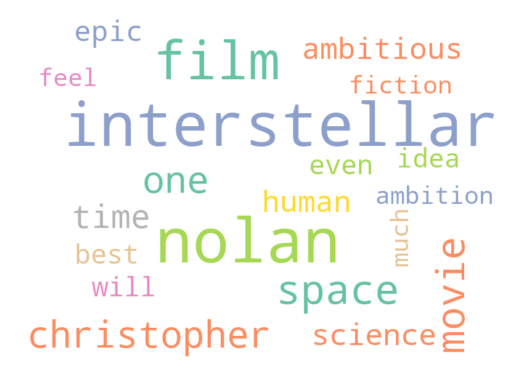

In [84]:
name = "interstellar_2014"

interstellar = pd.json_normalize(data[name])
plot_wordcloud(interstellar, name)

### Plot word frequency

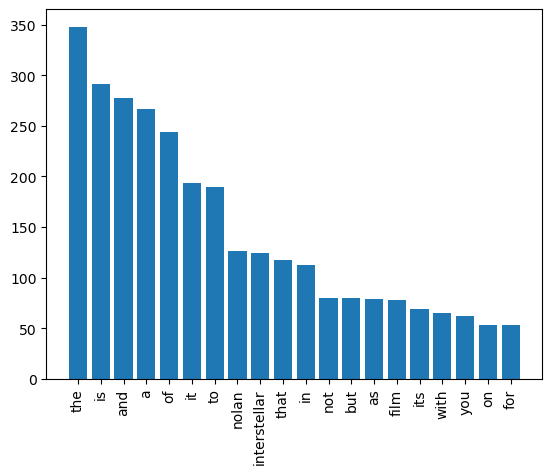

In [85]:
df_word_count = create_df_wordcount(interstellar)

# limit to the 20 most frequent words
df_pl = df_word_count.iloc[0:20, :]

plt.bar(x=df_pl["word"], height=df_pl["count"])
plt.xticks(rotation=90);

### Sentiment score

In [92]:
text = create_wordstring(interstellar)

print("AFINN:\t", afinn.score(text))
print("vader:\t", vader_sia.polarity_scores(text)["compound"])

AFINN:	 646.0
vader:	 1.0


## Dune

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi0.wp.com%2Fnerdmuch.com%2Fwp-content%2Fuploads%2F2019%2F07%2Fdune-movie.jpg&f=1&nofb=1&ipt=9aca5a0f374877be1b804400befe5665f7e3dea66a3e0327f993b70573d47ece&ipo=images" style="width:800px;"/>

### Word clouds

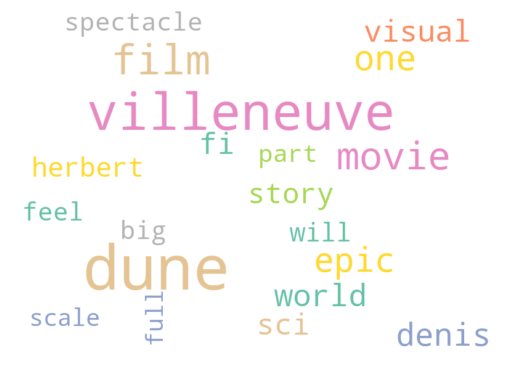

In [76]:
name = "dune_2021"

dune = pd.json_normalize(data[name])
plot_wordcloud(dune, name)

### Plot word frequency

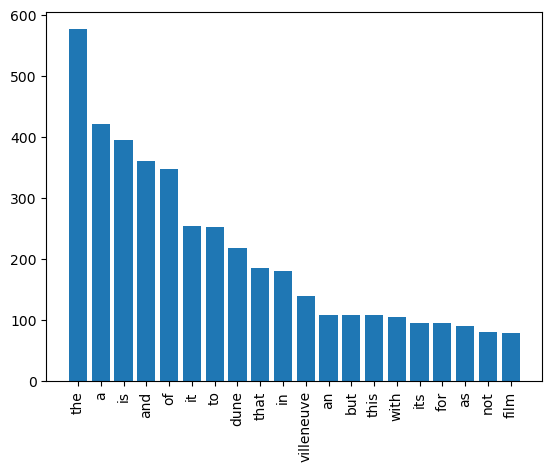

In [77]:
df_word_count = create_df_wordcount(dune)

# limit to the 20 most frequent words

df_pl = df_word_count.iloc[0:20, :]

plt.bar(x=df_pl["word"], height=df_pl["count"])
plt.xticks(rotation=90);

### Sentiment score

In [93]:
text = create_wordstring(dune)

print("AFINN:\t", afinn.score(text))
print("vader:\t", vader_sia.polarity_scores(text)["compound"])

AFINN:	 1099.0
vader:	 1.0


## Shining

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fstatic2.cbrimages.com%2Fwordpress%2Fwp-content%2Fuploads%2F2019%2F06%2Fshining-hallway-header.jpg&f=1&nofb=1&ipt=8a37a7bc3b1f5baa19ae3dd4327a6089fa016a2e5b3cf69d51d2035e50c2ac68&ipo=images" style="width:800px;"/>

### Word clouds

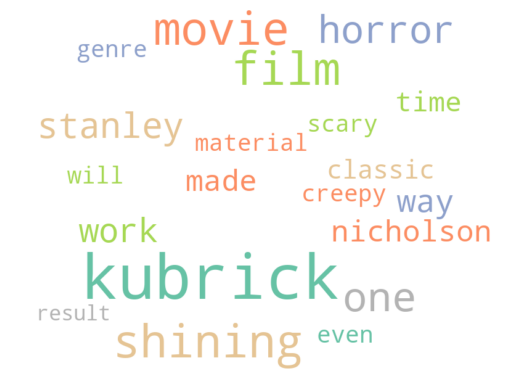

In [79]:
name = "shining"

shining = pd.json_normalize(data[name])
plot_wordcloud(shining, name)

### Plot word frequency

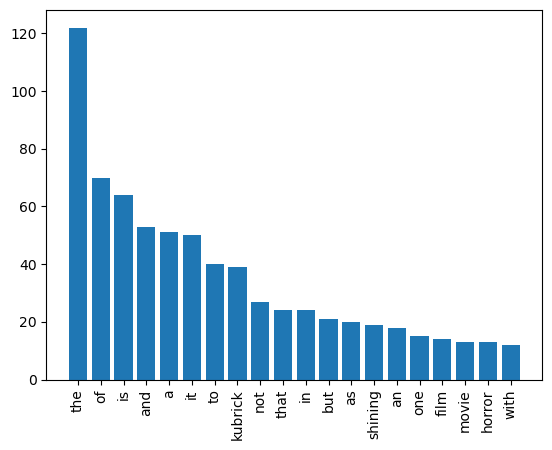

In [80]:
df_word_count = create_df_wordcount(shining)

# limit to the 20 most frequent words

df_pl = df_word_count.iloc[0:20, :]

plt.bar(x=df_pl["word"], height=df_pl["count"])
plt.xticks(rotation=90);

### Sentiment score

In [94]:
text = create_wordstring(shining)

print("AFINN:\t", afinn.score(text))
print("vader:\t", vader_sia.polarity_scores(text)["compound"])

AFINN:	 7.0
vader:	 0.1565
